In [1]:
import pandas as pd
import numpy as np
import datetime as dt

df_clean = pd.read_csv('../data/processed/data_clean_uk.csv')

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349199 entries, 0 to 349198
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   349199 non-null  int64         
 1   InvoiceNo    349199 non-null  int64         
 2   InvoiceDate  349199 non-null  datetime64[ns]
 3   TotalPrice   349199 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 10.7 MB


In [2]:
last_order_date = df_clean['InvoiceDate'].max()
print(f"Data da última transação: {last_order_date.strftime('%Y-%m-%d')}")

snapshot_date = last_order_date + dt.timedelta(days=1)
print(f"Data de referência (Snapshot Date): {snapshot_date.strftime('%Y-%m-%d')}")

print(f"Dataset cobre o período de {df_clean['InvoiceDate'].min().strftime('%Y-%m-%d')} até {last_order_date.strftime('%Y-%m-%d')}")

Data da última transação: 2011-12-09
Data de referência (Snapshot Date): 2011-12-10
Dataset cobre o período de 2010-12-01 até 2011-12-09


In [3]:
rfm_table = df_clean.groupby('CustomerID').agg(
    LastPurchaseDate = ('InvoiceDate', 'max'),
    Frequency = ('InvoiceNo', 'nunique'),
    Monetary = ('TotalPrice', 'sum')
).reset_index()

rfm_table.head()

,CustomerID,LastPurchaseDate,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,11,4196.01
2,12748,2011-12-09 12:20:00,209,33053.19
3,12749,2011-12-06 09:56:00,5,4090.88
4,12820,2011-12-06 15:12:00,4,942.34


In [4]:
rfm_table['Recency'] = (snapshot_date - rfm_table['LastPurchaseDate']).dt.days

rfm_table.drop('LastPurchaseDate', axis=1, inplace=True)

rfm_table = rfm_table[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

print("Tabela RFM criada com sucesso:")
rfm_table.head()

Tabela RFM criada com sucesso:


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,2,11,4196.01
2,12748,1,209,33053.19
3,12749,4,5,4090.88
4,12820,3,4,942.34


In [5]:
rfm_stats = rfm_table.describe()
print(rfm_stats)

         CustomerID      Recency    Frequency       Monetary
count   3920.000000  3920.000000  3920.000000    3920.000000
mean   15562.059694    92.208418     4.246429    1858.424653
std     1576.594671    99.533854     7.199202    7478.631256
min    12346.000000     1.000000     1.000000       3.750000
25%    14208.750000    18.000000     1.000000     298.185000
50%    15569.500000    51.000000     2.000000     644.975000
75%    16913.250000   143.000000     5.000000    1571.285000
max    18287.000000   374.000000   209.000000  259657.300000


In [6]:
rfm_table.to_csv('../data/processed/rfm_table_final.csv', index=False)

print("Tabela RFM salva em 'data/processed/rfm_table_final.csv'")

Fase 2 Concluída. Tabela RFM salva em 'data/processed/rfm_table_final.csv'


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
rfm_table = pd.read_csv('../data/processed/rfm_table_final.csv')

rfm_data = rfm_table[['Recency', 'Frequency', 'Monetary']]
customer_ids = rfm_table['CustomerID']

rfm_data.head()

,Recency,Frequency,Monetary
0,326,1,77183.60
1,2,11,4196.01
2,1,209,33053.19
3,4,5,4090.88
4,3,4,942.34


<function matplotlib.pyplot.show(close=None, block=None)>

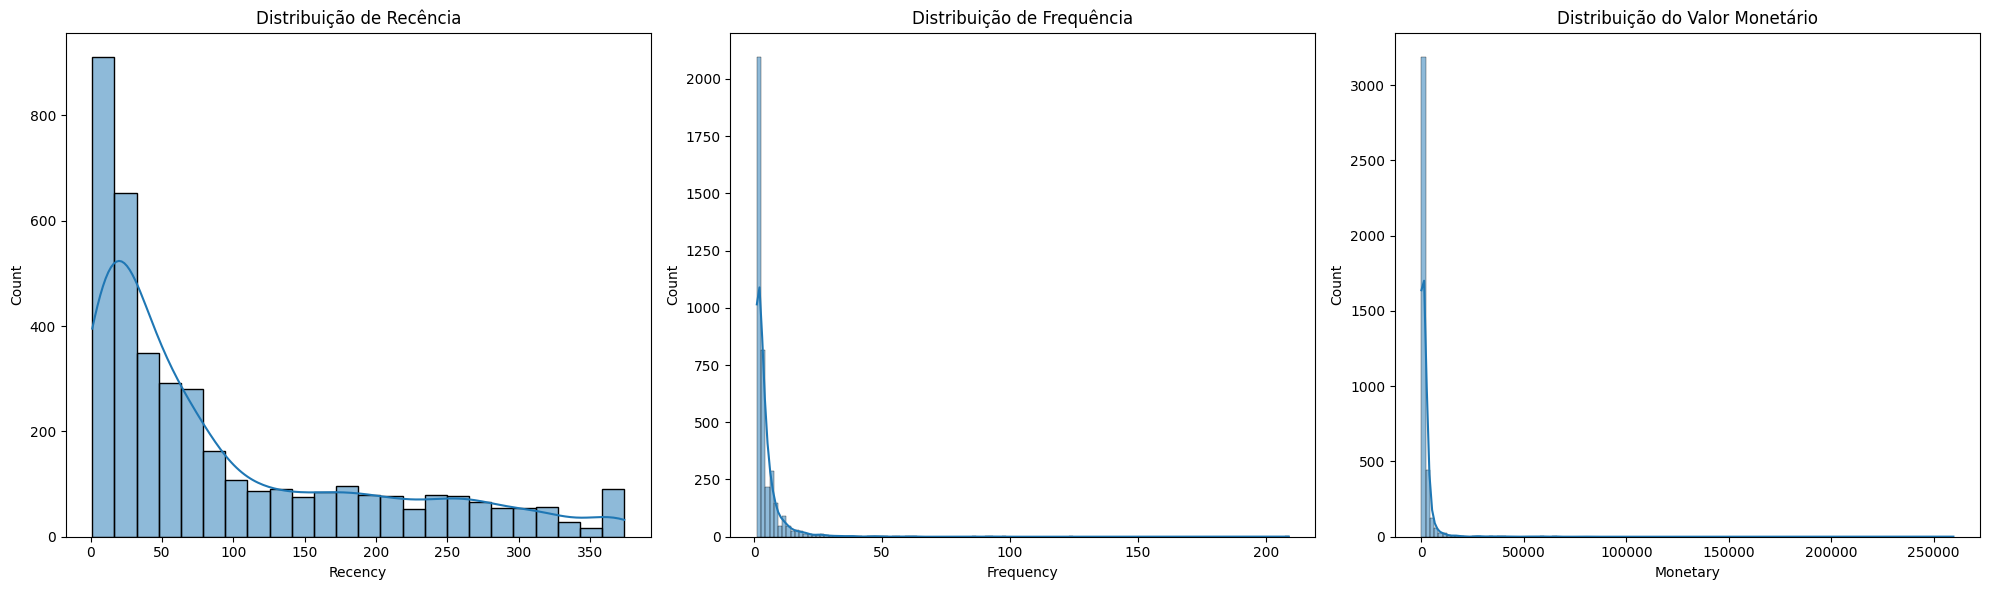

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(rfm_data['Recency'], kde=True, ax=axes[0])
axes[0].set_title('Distribuição de Recência')

sns.histplot(rfm_data['Frequency'], kde=True, ax=axes[1])
axes[1].set_title('Distribuição de Frequência')

sns.histplot(rfm_data['Monetary'], kde=True, ax=axes[2])
axes[2].set_title('Distribuição do Valor Monetário')

plt.tight_layout()
plt.show

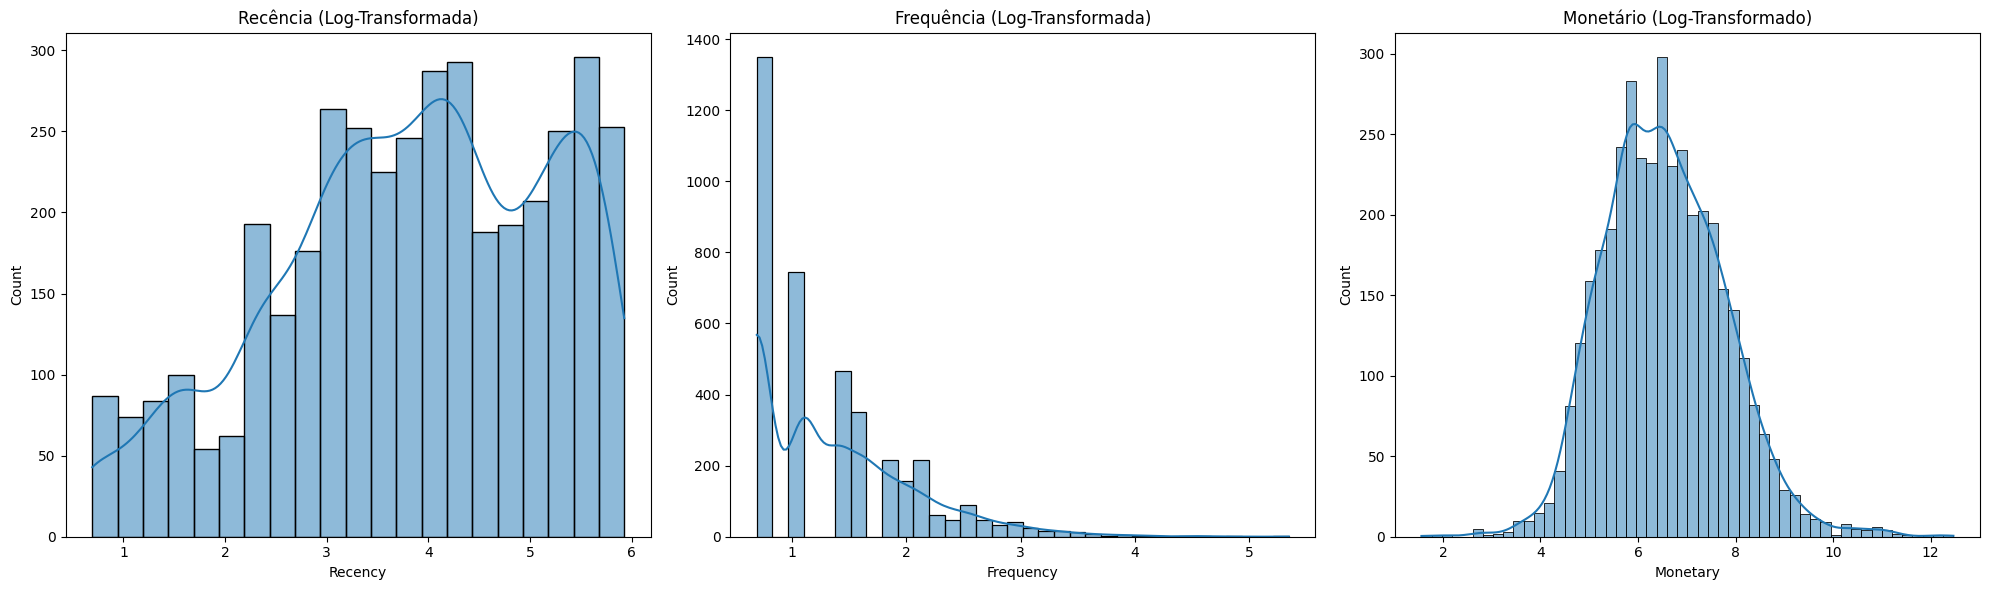

In [11]:
rfm_log = rfm_data.apply(np.log1p)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(rfm_log['Recency'], kde=True, ax=axes[0]).set_title('Recência (Log-Transformada)')
sns.histplot(rfm_log['Frequency'], kde=True, ax=axes[1]).set_title('Frequência (Log-Transformada)')
sns.histplot(rfm_log['Monetary'], kde=True, ax=axes[2]).set_title('Monetário (Log-Transformado)')
plt.tight_layout()
plt.show()